In [19]:
import LibsControl
import numpy
import matplotlib.pyplot as plt

import servo_identification

#load dynamics from log file
def load_from_file(file_name, dt):
    v = numpy.loadtxt(file_name)

    u = numpy.array(v[:, 1:3])
    x = numpy.array(v[:, 3:5])


    t = numpy.arange(x.shape[0])*dt

    return u, x, t

def difference(x):
    #add velocity terms
    x_pad = numpy.zeros((1, x.shape[1]))
    x_tmp = numpy.concatenate([x_pad, x], axis=0)

    #estimate velocity term
    dx = x_tmp[1:, :]  - x_tmp[0:-1, :]

    return dx

def state_augmentation(x):   
    #zero initial conditions
    x_aug = x - x[0]

    x_aug = x_aug - numpy.mean(x_aug, axis=0)

    vel = difference(x_aug[:, 0:2])
    x_aug = numpy.concatenate([x_aug, vel], axis=1)

    return x_aug



def plot_results(t_result, u_result, x_ref, x_pred, steps_start = 0 , steps_end = -1, dt = 1.0/250.0):

    plt.clf()

    axis_count = 4
    if x_ref.shape[1] == 4:
        axis_count+= 2

    fig, axs = plt.subplots(axis_count, 1, figsize=(8, 2*5))


    u_result*= 60.0/(2.0*numpy.pi)


    axs[0].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 0], color="purple")
    axs[0].set_xlabel("time [s]")
    axs[0].set_ylabel("control forward")
    axs[0].grid()

    axs[1].plot(t_result[steps_start:steps_end], u_result[steps_start:steps_end, 1], color="purple")
    axs[1].set_xlabel("time [s]")
    axs[1].set_ylabel("control turn")
    axs[1].grid()


    axs[2].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 0], label="ground truth", color="red")
    axs[2].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 0], label="prediction", color="blue")
    axs[2].set_xlabel("time [s]")
    axs[2].set_ylabel("distance [mm]")
    axs[2].legend()
    axs[2].grid()

    axs[3].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 1]*180.0/numpy.pi, color="red")
    axs[3].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 1]*180.0/numpy.pi, color="blue")
    axs[3].set_xlabel("time [s]")
    axs[3].set_ylabel("angle [deg]")
    axs[3].grid()


    if axis_count == 6:
        axs[4].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 2]/dt, label="ground truth", color="red")
        axs[4].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 2]/dt, label="prediction", color="blue")
        axs[4].set_xlabel("time [s]")
        axs[4].set_ylabel("velocity [mm/s]")
        axs[4].legend()
        axs[4].grid()

        axs[5].plot(t_result[steps_start:steps_end], x_ref[steps_start:steps_end, 3]*(180.0/numpy.pi)/dt, color="red")
        axs[5].plot(t_result[steps_start:steps_end], x_pred[steps_start:steps_end, 3]*(180.0/numpy.pi)/dt, color="blue")
        axs[5].set_xlabel("time [s]")
        axs[5].set_ylabel("angular velocity [deg/s]")
        axs[5].grid()
        
    

    #fig.legend()


def matrix_to_c(name, x, eps = 10**-10):

    x_tmp = x.copy()

    x_tmp[numpy.where(numpy.abs(x_tmp) < eps)] = 0.0

    result_str = ""

    result_str+= "float " + name + "[] = {\n"
    for m in range(x.shape[0]):
        result_str+= "\t\t"
        for n in range(x.shape[1]):
            result_str+= str(numpy.float32(x_tmp[m][n]))
            if m == x.shape[0]-1 and n == x.shape[1]-1:
                result_str+= " "
            else:
                result_str+= ", "
       
        if m != x.shape[0]-1:
            result_str+= "\n"

    result_str+= "};\n"

    return result_str


In [20]:
#obtain model
dt = 1.0/250.0
u_result, x_result, t_result = load_from_file("./data/run_1.txt", dt)


#normalise speed

x_ref = state_augmentation(x_result.copy())
x_ref = x_ref[1:]

print(u_result.shape, )


n_samples = 8000
u_result = u_result[0:n_samples, :]
x_ref    = x_ref[0:n_samples, :]
x_result    = x_result[0:n_samples, :]
t_result = t_result[0:n_samples]


a_est, b_est = servo_identification.robot_identification("./data/run_2.txt", dt)


tau = a_est[3][3]
k   = b_est[3][1]/(1.0 - tau)
k*= 1.3 

tau = 0.92

a = tau
b = (1.0 - tau)*k


print("tau = ", tau)
print("k = ", k)
print("a = ", a)
print("b = ", b)

a_est[3][3] = a
b_est[3][1] = b



#identification
#a_est, b_est = LibsControl.rls_identification(u_result, x_ref)
#a_est, b_est = LibsControl.krls_identification(u_result, x_ref)


c_est = numpy.eye(a_est.shape[0])
    


print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")
print("mat_c = \n", c_est, "\n\n")
print("poles = \n")
print(numpy.linalg.eigvals(a_est))



print(numpy.linalg.eigvals(a_est))

print("symmetrised model\n")
print("mat_a = \n", a_est, "\n\n")
print("mat_b = \n", b_est, "\n\n")

n_steps  = u_result.shape[0]
n_inputs = u_result.shape[1]
n_states = x_ref.shape[1]   


(10661, 2)
tau =  0.92
k =  0.1859306676483852
a =  0.92
b =  0.01487445341187081
mat_a = 
 [[1.        0.        1.        0.       ]
 [0.        1.        0.        1.       ]
 [0.        0.        0.9189645 0.       ]
 [0.        0.        0.        0.92     ]] 


mat_b = 
 [[0.         0.        ]
 [0.         0.        ]
 [0.67986299 0.        ]
 [0.         0.01487445]] 


mat_c = 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 


poles = 

[1.        1.        0.9189645 0.92     ]
[1.        1.        0.9189645 0.92     ]
symmetrised model

mat_a = 
 [[1.        0.        1.        0.       ]
 [0.        1.        0.        1.       ]
 [0.        0.        0.9189645 0.       ]
 [0.        0.        0.        0.92     ]] 


mat_b = 
 [[0.         0.        ]
 [0.         0.        ]
 [0.67986299 0.        ]
 [0.         0.01487445]] 




<Figure size 640x480 with 0 Axes>

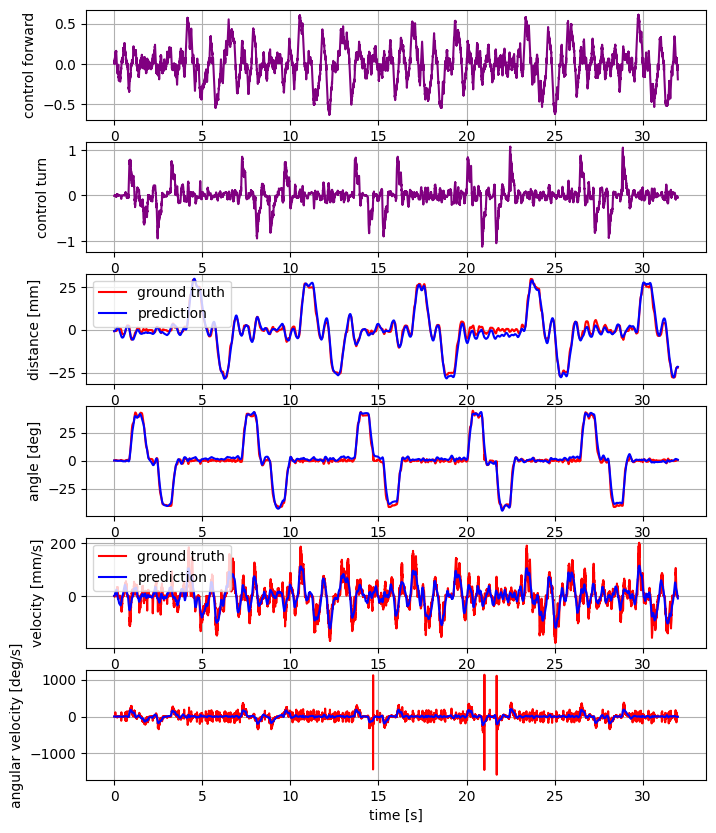

In [21]:
#model verification
#set same inputs and initial conditions



ds = LibsControl.DynamicalSystemDiscrete(a_est, b_est, c_est)    

x_initial = numpy.expand_dims(x_ref[0], axis=0).T
ds.reset(x_initial)

x_hat_result = []

for n in range(n_steps):

    u = u_result[n, :]
    u = numpy.expand_dims(u, axis=0).T

    x, y = ds.forward_state(u)

    x_hat_result.append(x[:, 0])

x_hat_result = numpy.array(x_hat_result)


#plot results
count = int(20*1.0/dt)
plot_results(t_result, u_result, x_ref, x_hat_result, 0)


In [22]:
#controller synthetis

#create loss weighting matrices (diagonal)
q = numpy.diag([ 1.0, 1.0, 0.0, 0.0] )
r = numpy.diag( [10.0**8, 5*10.0**2])  



noise_q = 0.001*numpy.eye(4)

s = 16.938

noise_r = 0.001*numpy.diag([2*s, 2*s, s, s])
    

#solve LQG controller 
lqg = LibsControl.LQGDiscrete(a_est, b_est, c_est, q, r, noise_q, noise_r, 100.0)

print("controller")
print("k  = \n", lqg.k, "\n")
print("ki = \n", lqg.ki, "\n")
print("f  = \n", lqg.f, "\n")
print("\n\n")


print("poles OL = ", numpy.linalg.eigvals(a_est))
print("poles CL = ", numpy.linalg.eigvals(a_est - b_est@lqg.k))



controller
k  = 
 [[5.96139928e-03 0.00000000e+00 5.91246514e-02 0.00000000e+00]
 [0.00000000e+00 1.07921163e+00 0.00000000e+00 7.89140471e+00]] 

ki = 
 [[9.80100270e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.21705927e-02 0.00000000e+00 0.00000000e+00]] 

f  = 
 [[0.36033609 0.         0.13288806 0.        ]
 [0.         0.36056542 0.         0.1332538 ]
 [0.06644403 0.         0.13166018 0.        ]
 [0.         0.0666269  0.         0.13192691]] 




poles OL =  [1.        1.        0.9189645 0.92     ]
poles CL =  [0.93938392+0.01945831j 0.93938392-0.01945831j 0.90130983+0.07945398j
 0.90130983-0.07945398j]


'\nplt.plot(du_result[:, 0], label="du[0] change")\nplt.plot(du_result[:, 1], label="du[1] change")\nplt.show()\n'

<Figure size 640x480 with 0 Axes>

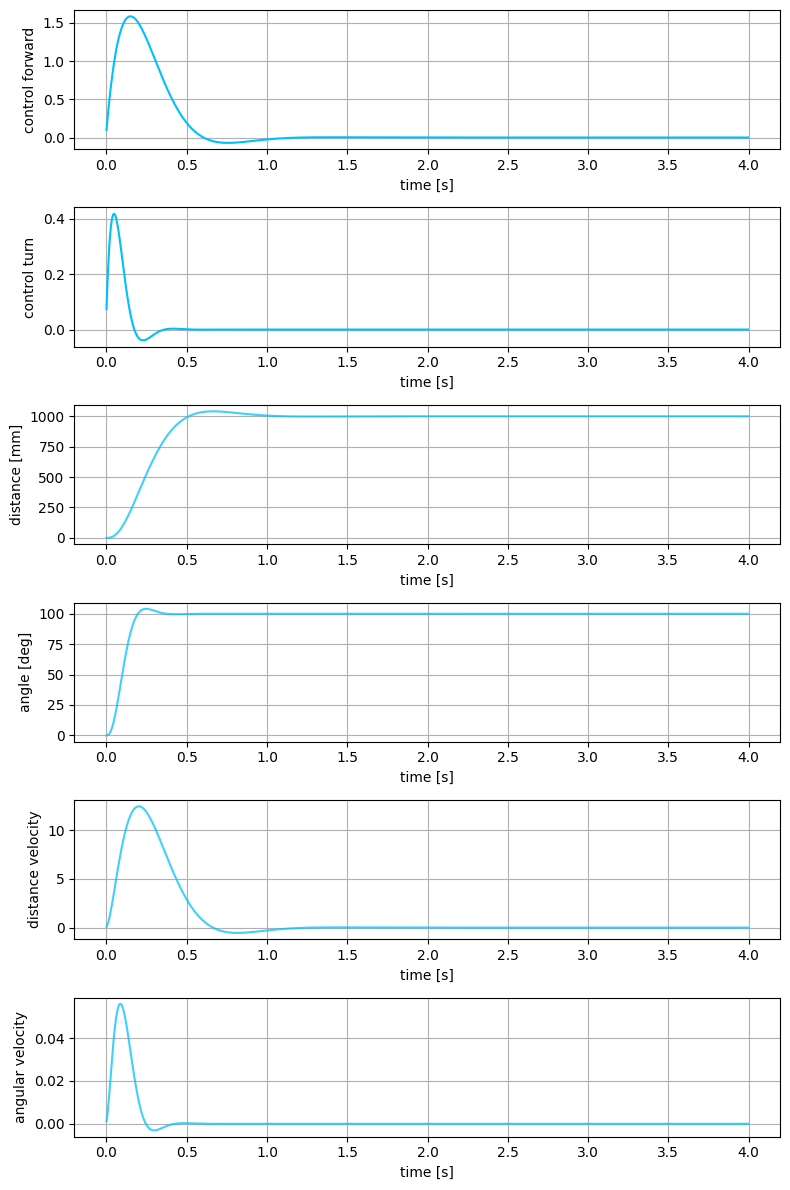

In [23]:
#process simulation

n_max = int(4.0/dt)

#required output, 1 meter, 100degrees
xr = numpy.array([[1000.0, 100.0*numpy.pi/180.0, 0.0, 0.0]]).T
#xr = numpy.array([[1000.0, 100.0*numpy.pi/180.0]]).T

#plant state
x = numpy.zeros((a_est.shape[0], 1))

#initial error integral
integral_action = numpy.zeros((b_est.shape[1], 1))

x_hat = numpy.zeros(x.shape)

#result log
t_result = [] 
u_result = []
x_result = []
int_result = []



for n in range(n_max):

    #compute controller output
    u, integral_action, x_hat = lqg.forward(xr, x, integral_action, x_hat)
    
    #compute plant output
    y = c_est@x
    x = a_est@x + b_est@u
    
    t_result.append(n*dt)
    u_result.append(u[:, 0].copy())
    x_result.append(x[:, 0].copy())

    int_result.append(integral_action[:, 0].copy())
    
    
t_result = numpy.array(t_result)
u_result = numpy.array(u_result)

x_result = numpy.array(x_result)

int_result = numpy.array(int_result)

du_result = x_result[1:, :] - x_result[0:-1, :]

#plot results
#convert angle to degrees
x_result[:, 1]*= 180.0/numpy.pi 

LibsControl.plot_closed_loop_response(t_result, u_result, x_result, x_hat = None, file_name = "lqg_controller_output.png", u_labels = ["control forward", "control turn"], x_labels = ["distance [mm]", "angle [deg]", "distance velocity", "angular velocity"])

'''
plt.plot(du_result[:, 0], label="du[0] change")
plt.plot(du_result[:, 1], label="du[1] change")
plt.show()
'''


In [24]:
#print c-like arrays
print(matrix_to_c("a",  a_est))
print(matrix_to_c("b",  b_est))
print(matrix_to_c("c",  c_est))
print(matrix_to_c("k",  lqg.k))
print(matrix_to_c("ki", lqg.ki))
print(matrix_to_c("f",  lqg.f))




float a[] = {
		1.0, 0.0, 1.0, 0.0, 
		0.0, 1.0, 0.0, 1.0, 
		0.0, 0.0, 0.9189645, 0.0, 
		0.0, 0.0, 0.0, 0.92 };

float b[] = {
		0.0, 0.0, 
		0.0, 0.0, 
		0.679863, 0.0, 
		0.0, 0.014874454 };

float c[] = {
		1.0, 0.0, 0.0, 0.0, 
		0.0, 1.0, 0.0, 0.0, 
		0.0, 0.0, 1.0, 0.0, 
		0.0, 0.0, 0.0, 1.0 };

float k[] = {
		0.005961399, 0.0, 0.059124652, 0.0, 
		0.0, 1.0792116, 0.0, 7.8914046 };

float ki[] = {
		9.801003e-05, 0.0, 0.0, 0.0, 
		0.0, 0.04217059, 0.0, 0.0 };

float f[] = {
		0.3603361, 0.0, 0.13288806, 0.0, 
		0.0, 0.36056542, 0.0, 0.1332538, 
		0.06644403, 0.0, 0.13166018, 0.0, 
		0.0, 0.0666269, 0.0, 0.13192691 };

